In [2]:
import os
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm.notebook import tqdm 
from sklearn.metrics import accuracy_score, classification_report

import torch
import torch.nn.functional as F
from torch.utils import data
from torchinfo import summary
import torch.nn as nn
import torch.optim as optim

import wandb

# 读取数据

In [3]:
lr = 0.0005
# load
label_col_name = 'label_5'
with open(f'./np_data/nparray_all_data.pkl', 'rb') as f:
    nparray_all_data = pickle.load(f)
with open(f'./np_data/nparray_all_label_{label_col_name}.pkl', 'rb') as f:
    nparray_all_label = pickle.load(f)

In [4]:
n = len(nparray_all_data)
##划分训练/测试集
train_nums = int(n*0.8)
val_nums = int(n*0.1)
print(f"All data shape: {nparray_all_data.shape}, Lebel data shape: {nparray_all_label.shape}")
print(f'train_nums: {train_nums}, val_nums: {val_nums}, test_nums: {n-train_nums-val_nums}')

train_data = nparray_all_data[:train_nums]
train_label = nparray_all_label[:train_nums]

val_data = nparray_all_data[train_nums:train_nums+val_nums]
val_label = nparray_all_label[train_nums:train_nums+val_nums]

test_data = nparray_all_data[train_nums+val_nums:]
test_label = nparray_all_label[train_nums+val_nums:]

print(train_data.shape)

All data shape: (2964051, 100, 5), Lebel data shape: (2964051,)
train_nums: 2371240, val_nums: 296405, test_nums: 296406
(2371240, 100, 5)


In [5]:
# 计算 train_label 中三种分类的比例
y_train = torch.tensor(train_label).to(torch.int64)
class_counts = torch.bincount(y_train, minlength=3)
class_weights = 1.0 / class_counts.float()
class_weights = class_weights / class_weights.sum()  # 归一化，使总和为1

class_weights = class_weights.to(dtype=torch.float32)

print("Class weights:", class_weights)

Class weights: tensor([0.4473, 0.1001, 0.4525])


## GPU准备

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(f"Using device: {torch.cuda.get_device_name(device)}")

cuda:0
Using device: NVIDIA GeForce RTX 4070


## 准备dataset

In [7]:
class Dataset(data.Dataset):
    def __init__(self, data, label,  num_classes, T):
        self.T = T

        # self.x = torch.tensor(data).to(torch.float32).unsqueeze(1).to(device)
        self.x = torch.tensor(data).to(torch.float32).to(device)

        # self.y = F.one_hot(torch.tensor(label[T - 1:].astype(np.int64)), num_classes=3)
        self.y = torch.tensor(label.astype(np.int64)).to(device)
    
        self.length = len(self.x)

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [8]:
batch_size = 128

dataset_train = Dataset(data=train_data,label=train_label, num_classes=3, T=100)
dataset_val   = Dataset(data=val_data,  label=val_label,   num_classes=3, T=100)
dataset_test  = Dataset(data=test_data, label=test_label,  num_classes=3, T=100)

train_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)
val_loader   = torch.utils.data.DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=False)
test_loader  = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False)

print(dataset_train.x.shape, dataset_train.y.shape, dataset_train.x.requires_grad, dataset_train.y.requires_grad,)
print(dataset_val.x.shape, dataset_val.y.shape, dataset_val.x.requires_grad, dataset_val.y.requires_grad,)
print(dataset_test.x.shape, dataset_test.y.shape, dataset_test.x.requires_grad, dataset_test.y.requires_grad,)

print(dataset_train.x.device)
print(dataset_train.y.device)

torch.Size([2371240, 100, 5]) torch.Size([2371240]) False False
torch.Size([296405, 100, 5]) torch.Size([296405]) False False
torch.Size([296406, 100, 5]) torch.Size([296406]) False False
cuda:0
cuda:0


# 定义模型

In [9]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.1)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        
        return F.softmax(out, dim=1)

# 模型参数定义
input_size = 5
hidden_size = 64
num_layers = 1
num_classes = 3

model_lstm = LSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)
model_lstm.to(device);

c:\Users\ylc\anaconda3\envs\companionGLM\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [10]:
# summary(model, (234, 1, 100, 32))
summary(model_lstm, (1, 100, 5))

Layer (type:depth-idx)                   Output Shape              Param #
LSTMModel                                [1, 3]                    --
├─LSTM: 1-1                              [1, 100, 64]              18,176
├─Dropout: 1-2                           [1, 64]                   --
├─Linear: 1-3                            [1, 3]                    195
Total params: 18,371
Trainable params: 18,371
Non-trainable params: 0
Total mult-adds (M): 1.82
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.07
Estimated Total Size (MB): 0.13

# 训练模型

In [11]:
# criterion_lstm = nn.CrossEntropyLoss()
criterion_lstm = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer_lstm = optim.Adam(model_lstm.parameters(), lr)
# rmsprop
# optimizer = optim.RMSprop(model_lstm.parameters(), lr, alpha=0.9)

def batch_gd_lstm(model, criterion, optimizer, train_loader, test_loader, epochs, patience=15):
    wandb.init(
        # set the wandb project where this run will be logged
        project="Quant-AI-model",

        # track hyperparameters and run metadata
        config={
        "learning_rate": lr,
        "architecture": "LSTM",
        "dataset": f"{label_col_name}",
        "epochs": epochs,
        }
    )
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    best_test_loss = np.inf
    best_test_epoch = 0
    no_improve_epochs = 0

    for it in tqdm(range(epochs)):
        model.train()
        t0 = datetime.now()
        train_loss = []
        correct_train_preds = 0
        total_train_preds = 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())

            _, predicted = torch.max(outputs.data, 1)
            total_train_preds += targets.size(0)
            correct_train_preds += (predicted == targets).sum().item()
        
        train_loss = np.mean(train_loss)
        train_acc = correct_train_preds / total_train_preds
    
        model.eval()
        test_loss = []
        correct_test_preds = 0
        total_test_preds = 0
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                test_loss.append(loss.item())

                _, predicted = torch.max(outputs.data, 1)
                total_test_preds += targets.size(0)
                correct_test_preds += (predicted == targets).sum().item()
        test_loss = np.mean(test_loss)
        test_acc = correct_test_preds / total_test_preds

        wandb.log({"train_loss": train_loss, "train_acc": train_acc, "test_loss": test_loss, "test_acc": test_acc})

        train_losses[it] = train_loss
        test_losses[it] = test_loss
        
        if test_loss < best_test_loss:
            torch.save(model.state_dict(), f'best_val_model_lstm_{label_col_name}.pth')
            best_test_loss = test_loss
            best_test_epoch = it
            no_improve_epochs = 0
            print('model saved')
        else:
            no_improve_epochs += 1

        dt = datetime.now() - t0
        print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {test_loss:.4f}, Duration: {dt}, Best Val Epoch: {best_test_epoch}')

        if no_improve_epochs >= patience:
            print('Early stopping')
            wandb.finish()
            break
    
    torch.save(model.state_dict(), f'final_model_lstm_{label_col_name}.pth')
    wandb.finish()
    return train_losses, test_losses


In [12]:
for inputs, targets in train_loader:
    print('inputs.shape:', inputs.shape)
    print('targets.shape:', targets.shape)
    outputs = model_lstm(inputs)
    print('outputs.shape:', outputs.shape)
    break

inputs.shape: torch.Size([128, 100, 5])
targets.shape: torch.Size([128])
outputs.shape: torch.Size([128, 3])


In [ ]:
train_losses, val_losses = batch_gd_lstm(model_lstm, criterion_lstm, optimizer_lstm, train_loader, val_loader, epochs=35)

  0%|          | 0/35 [00:00<?, ?it/s]

model saved
Epoch 1/35, Train Loss: 1.0549, Validation Loss: 1.1180, Duration: 0:00:41.075676, Best Val Epoch: 0
model saved
Epoch 2/35, Train Loss: 1.0476, Validation Loss: 1.0895, Duration: 0:00:40.964772, Best Val Epoch: 1
model saved
Epoch 3/35, Train Loss: 1.0390, Validation Loss: 1.0878, Duration: 0:00:40.262575, Best Val Epoch: 2
model saved
Epoch 4/35, Train Loss: 1.0290, Validation Loss: 1.0784, Duration: 0:00:40.668953, Best Val Epoch: 3
model saved
Epoch 5/35, Train Loss: 1.0222, Validation Loss: 1.0727, Duration: 0:00:40.283830, Best Val Epoch: 4
Epoch 6/35, Train Loss: 1.0171, Validation Loss: 1.0769, Duration: 0:00:40.278539, Best Val Epoch: 4
Epoch 7/35, Train Loss: 1.0130, Validation Loss: 1.0776, Duration: 0:00:40.785780, Best Val Epoch: 4
Epoch 8/35, Train Loss: 1.0085, Validation Loss: 1.0780, Duration: 0:00:40.155105, Best Val Epoch: 4
Epoch 9/35, Train Loss: 1.0053, Validation Loss: 1.0774, Duration: 0:00:40.748909, Best Val Epoch: 4
Epoch 10/35, Train Loss: 1.0019

test_acc,▁▆▇▇█▇█▇█▇▇▇█▆▇▇▆▇▆▆
test_loss,█▄▃▂▁▂▂▂▂▃▃▃▃▅▅▄▄▅▅▅
train_acc,▁▁▃▄▅▅▆▆▆▆▇▇▇▇▇█████
train_loss,█▇▇▆▅▅▄▄▃▃▃▃▂▂▂▂▂▁▁▁
test_acc,0.40603
test_loss,1.09689
train_acc,0.54437
train_loss,0.9779


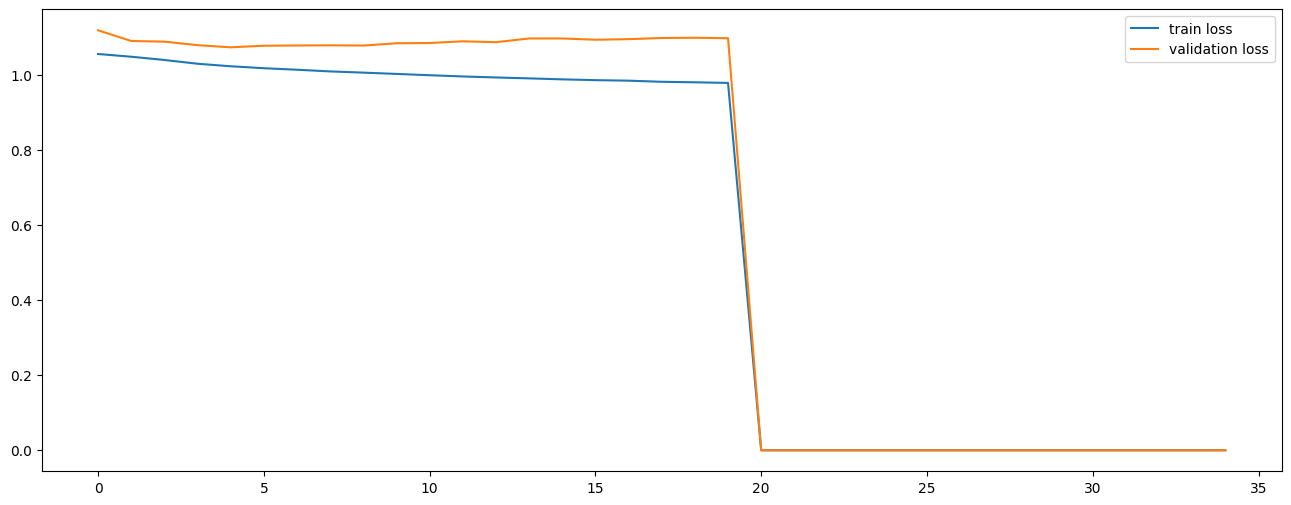

In [ ]:
plt.figure(figsize=(16,6))
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.legend()